# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import multiprocessing
import numpy as np
import torch.utils.data as data

from torch import nn

from sklearn.model_selection import train_test_split
from lightning import Trainer
from torch.optim.lr_scheduler import StepLR

from src.util.torch import resolve_torch_device
from src.util.hsi import (
    extract_patches,
    reduce_hsi_dim,
    train_test_band_patch_split,
    preprocess_hsi,
    to_bin_labels_mask,
    to_bin_labels,
    to_pu_labels,
    PreProcessType,
    DimReductionType,
)
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.model.lenet import FullyConvolutionalLeNet, PuLeNet
from src.visualization.plot import (
    plot_segmentation_comparison,
    plot_numbers_distribution,
    plot_epoch_generic_comparison,
    plot_epoch_generic,
)
from src.data.dataset_decorator import UnlabeledDatasetDecorator
from src.util.reporting import (
    create_model_name,
    report_run,
    read_report_to_show,
    lightning_metrics,
)
from src.util.list_ext import smooth_moving_average
from src.util.loss import PULoss

2. Prepare env

In [2]:
learning_rate = 1e-3
num_epochs = 100
scheduler_step_size = num_epochs // 10
scheduler_gamma = 0.9

In [3]:
batch_size = 64
patch_size = 9
target_dim = 75
examples_per_class = []
smoth_window = 20

pre_process_type = PreProcessType.STANDARTIZATION
dim_reduction_type = DimReductionType.PCA

In [4]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

In [5]:
torch.cuda.empty_cache()

In [6]:
torch.set_float32_matmul_precision("medium")

In [7]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [8]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [9]:
_, image = preprocess_hsi(image, pre_process_type)

In [10]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

In [11]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [12]:
num_classes = len(np.unique(y))

f"Number of classes {num_classes}"

'Number of classes 17'

In [13]:
examples_per_class = [20] * num_classes

In [14]:
num_classes = 2

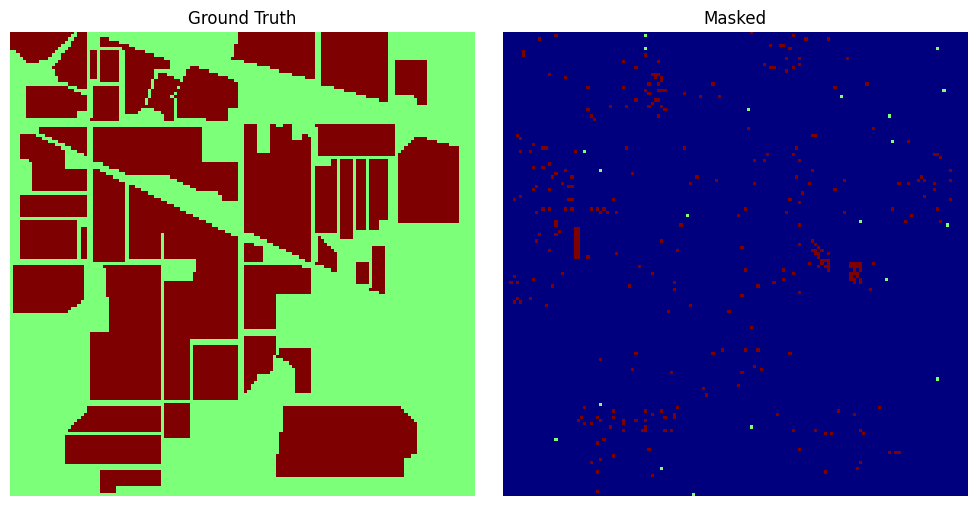

In [15]:
if examples_per_class:
    x_train, y_train, x_test, y_test, y_masked = train_test_band_patch_split(
        x, y, examples_per_class, "indian_pines"
    )

    plot_segmentation_comparison(
        to_bin_labels_mask(y).reshape(image_h, image_w),
        to_bin_labels_mask(y_masked).reshape(image_h, image_w),
        title2="Masked",
    )
else:
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=random_seed, stratify=y
    )

y = to_bin_labels(y)
y_train = to_bin_labels(y_train)
y_test = to_bin_labels(y_test)

x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, np.repeat(-1, len(x_test))))

In [16]:
x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(y, dtype=torch.long)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [17]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

'Setting num_workers to 24'

In [18]:
train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)
full_dataset = data.TensorDataset(x_tensor, y_tensor)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count,
    persistent_workers=True,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)
full_loader = data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    num_workers=cpu_count,
    persistent_workers=True,
)

In [19]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

'Training samples: 21025, Testing samples: 20685'

4. Train model

In [20]:
_, counts = np.unique(y_train, return_counts=True)

class_weights = 1.0 / counts 
class_weights = class_weights / class_weights.sum() 
class_weights = torch.tensor(class_weights, dtype=torch.float32)

class_weights

tensor([9.0918e-04, 9.4032e-01, 5.8770e-02])

In [21]:
_, counts = torch.unique(y_tensor, return_counts=True)

positive_prob = counts[1] / counts.sum()

positive_prob

tensor(0.4875)

In [22]:
from src.model.dbda import DBDA


loss_fun = PULoss(prior=positive_prob)

backbone = DBDA(
    band=target_dim,
    classes=1,
)

pred_extractor = lambda logits: (torch.sigmoid(logits) > 0.5).int()

In [23]:
model = HyperSpectralImageClassifier(
    backbone,
    num_classes,
    lr=learning_rate,
    loss_fun=loss_fun,
    # scheduler=lambda opt: StepLR(
    #     opt, step_size=scheduler_step_size, gamma=scheduler_gamma
    # ),
    pred_extractor=pred_extractor,
)

trainer = Trainer(accelerator="auto", devices=1, max_epochs=num_epochs)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [24]:
trainer.fit(
    model,
    train_loader,
    # test_loader,
)

/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | PULoss               | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.602     Total estimated model params size (MB)
47        Modules in train mode
0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
# smothed_train = smooth_moving_average(
#     [it.loss.cpu() for it in model.train_metrics], smoth_window
# )
# smothed_eval = smooth_moving_average(
#     [it.loss.cpu() for it in model.val_metrics], smoth_window
# )

# plot_epoch_generic_comparison(smothed_train, smothed_eval)

In [ ]:
# smooth_f1 = smooth_moving_average(
#     [it.f1.cpu() for it in model.val_metrics], smoth_window
# )

# plot_epoch_generic(smooth_f1, desc="f1")

In [ ]:
validation_result = trainer.validate(model, full_loader)

validation_result

5. Display prediction

In [ ]:
y_pred = trainer.predict(model, predict_loader)

In [ ]:
y_pred = torch.cat(y_pred, dim=0)
# y_pred = pred_extractor(y_pred)
y_pred = y_pred.reshape(image_h, image_w)

In [ ]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.numpy())

6. Write report

In [ ]:
model_name = create_model_name("ground_indian_pines_", examples_per_class)
model_category = "lenet"

report_run(
    model_name=model_name,
    model_category=model_category,
    run_desc="Std, more epochs, PULoss, pass whole dataset",
    run_params={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "batch_size": batch_size,
        "patch_size": patch_size,
        "target_dim": target_dim,
        "scheduler_step_size": scheduler_step_size,
        "scheduler_gamma": scheduler_gamma,
        "pre_process_type": str(pre_process_type),
        "dim_reduction_type": str(dim_reduction_type),
    },
    run_metrics=lightning_metrics(validation_result),
)

In [ ]:
read_report_to_show(model_name, sort_by_metric="f1")

In [ ]:
read_report_to_show(model_name, sort_by_metric="OA", model_category=model_category)